### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 21}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 22 is here the size of the considered amino acid alphabet.


In [1]:
import numpy as np
import tensorflow as tf
import logomaker
from time import time
from IPython.display import Audio

import sequtils as su
import seq

### Create random genomes as toy data 

In [2]:
N = 8            # number of genomes
tile_size = 334  # tile size measured in amino acids
# A tile is a consecutive subsequence of _one_ contig/scaffold/chromosome.
# Tiles should be about gene-sized.

#genome_sizes = [[210,100], [30,220,150], [230,110,120,90], [180]] # in nucleotides
#insertPatterns = ["ATGATGATG", "CCCCCCCCCCCC"]
#genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns, mutationProb=0.2, verbose=True)

genome_sizes = [[1000]] * 8
                # in nucleotides
insertPatterns = ["ATGGCAAGAATTCAATCTACTGCAAATAAAGAA",
                 ] 
genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns,
                               mutationProb=0.1, verbose=True)

Pattern ATGGCAAGAATTCAATCTACTGCAAATAAAGAA translates to  ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
  mutated to ATTGCAAGAATTCAGTCTACTGCAAACAAAGAC and inserted in genome 0 contig 0 at position 831
  mutated to ATGGCAAGAATTCAATCTACTGCAAATAAAGAA and inserted in genome 1 contig 0 at position 316
  mutated to ATGGCGAGAATTCAATCTACTGCAAAAAAAGAA and inserted in genome 2 contig 0 at position 889
  mutated to ATGGCAAGAATTCAATCTACTGCCAAAAACGAA and inserted in genome 3 contig 0 at position 431
  mutated to ATGGCAAGCATTCAATCTACTGCAAATAAGGAA and inserted in genome 4 contig 0 at position 203
  mutated to ATAGCAAGAATTCAATCTACTGCAAACAAAGAA and inserted in genome 5 contig 0 at position 662
  mutated to ATGGCAAGAATCCAATCTACCGCAAATAAAGAA and inserted in genome 6 contig 0 at position 33
  mutated to ATGGCAAGCATTCAATCTACTGCAAATAAAGAA and inserted in genome 7 contig 0 at position 23


In [3]:
#genomes

In [4]:
# background distribution observed in the data 
Q = seq.backGroundAAFreqs(genomes, True)

# uniform background distribution appears to be rather better
#Q = np.ones(21, dtype=np.float32)/21

background freqs:  15968.0 *
C 0.0328
K 0.0309
E 0.0318
W 0.0164
T 0.0594
G 0.0633
Y 0.0293
A 0.0648
I 0.0483
N 0.0325
V 0.0594
H 0.0321
S 0.0930
D 0.0316
F 0.0318
M 0.0177
R 0.0928
L 0.0920
P 0.0633
Q 0.0328
* 0.0440


#### Read in the genome

In [5]:
batch_size = 1  # number of tile per batch, constrained by RAM and gradient descent performance

X = seq.getNextBatch(genomes, batch_size, tile_size, verbose=False)
X.shape

(1, 8, 6, 334, 21)

In [6]:
def plotLogo(P, idxarray = None, pScores = None, max_print=5):
    """
    max_print  print up to this many logos
    """
    dfs = su.makeDFs(P.numpy())
    for i in range(min(U,max_print)):
        j = idxarray[i] if idxarray is not None else i
        profile_df = dfs[j]
        logo = logomaker.Logo(profile_df, vpad=.1, width=1)
        logo.style_xticks(anchor=0, spacing=1, rotation=45)
        logo.ax.set_ylabel('information (bits)')
        logo.ax.set_title(f"Profile {j}" + (f" score={pScores[j]:.1f}") if pScores is not None else "")

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 21 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{21}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 21 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

In [7]:
U = 100 # number of profiles to train
k = 11 # length of profiles

In [8]:
class SpecificProfile(tf.keras.Model):
    def __init__(self, k, alphabet_size, units, Q, **kwargs):
        super().__init__(**kwargs)
        # P_logit_init = tf.random.normal([k, alphabet_size, units], stddev=.5, dtype=tf.float32, seed=1)
        np.random.seed(1)
        P_logit_init = np.random.normal(scale=.5, size=[k, alphabet_size, units]).astype('float32')
        #P_logit_init[4,19,:] = 5 # Q
        #P_logit_init[5,12,:] = 5 # S
        #P_logit_init[6,4,:] = 5 # T
        if False: # to test whether the right pattern has low loss
            P_logit_init = -100 *np.ones([k, 21, units], dtype=np.float32)
            P_logit_init[0,15,:] = 5 # M
            P_logit_init[1,7,:] = 5 # A
            P_logit_init[2,16,:] = 5 # R
            P_logit_init[3,8,:] = 5 # I
            P_logit_init[4,19,:] = 5 # Q
            P_logit_init[5,12,:] = 5 # S
            P_logit_init[6,4,:] = 5 # T
            P_logit_init[7,7,:] = 5 # A
            P_logit_init[8,9,:] = 5 # N
            P_logit_init[9,1,:] = 5 # K
            P_logit_init[10,2,:] = 5 # E

        self.P_logit = tf.Variable(P_logit_init, trainable=True, name="P_logit") 
        self.Q = Q
        self.k = k
        self.alphabet_size = alphabet_size
        self.units = units

    def getP(self):
        # P1_logit = -1000 * tf.ones([self.k, 1, self.units])
        # P2_logit = tf.stack([P1_logit, self.P_logit], axis=1)
        P = tf.nn.softmax(self.P_logit, axis=1, name="P")
        return P
    
    def call(self, X):
        P = self.getP()
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        # Limit the odds-ratio, to prevent problemt with log(0).
        # Very bad matches of profiles are irrelevant anyways.
        ratio = tf.maximum(P/Q2, 1e-6)
        R = tf.math.log(ratio)

        X1 = tf.expand_dims(X,-1) # 1 input channel
        R1 = tf.expand_dims(R,-2) # 1 input channel
        Z1 = tf.nn.conv2d(X1, R1, strides=1,
                         padding='VALID', data_format="NHWC", name="Z")
        Z = tf.squeeze(Z1, 4) # remove input channel dimension

        S = tf.reduce_max(Z, axis=[2,3])
        return S, R

    # custom loss
    def loss(self, S):
        # overall fit of patterns
        L1 = -tf.reduce_sum(S)
        # L1 = -tf.reduce_sum(tf.reduce_max(S, axis=[0,2]))
        
        # homogeneity along pattern
        P = self.getP()
        H = -tf.reduce_sum(tf.math.multiply(P, tf.math.log(P)), axis=1) # entropy
        # standard deviation of entropies
        VH = tf.math.reduce_std(H, axis=0) # variance for each profile along site axis
        L2 = tf.reduce_mean(VH)
        
        # homogeneity between genomes
        # ignore the best score per genome, so that rather others are improved
        L3 = tf.reduce_sum(tf.reduce_max(S, axis=1)) # cancels out the best occurence from L1
        
        # other ideas: 
        # - std deviation of scores of different genomes
        L4 = tf.reduce_sum(tf.math.reduce_std(tf.reduce_max(S, axis=0), axis=0))
        # - minimum score of any genome
        
        return (L1+L3)/N + 50*L2, L2, L4 # + 100*L2 # (L1 + L3)/N #+ 100*L2

    @tf.function()
    def train_step(self, X):
        with tf.GradientTape() as tape:
            S, _ = self.call(X)
            L, _, _ = self.loss(S)

        grad = tape.gradient(L, self.P_logit)
        self.opt.apply_gradients([(grad, self.P_logit)])

    def train(self, X, epochs=1000):
        self.opt = tf.keras.optimizers.Adam(learning_rate=.1) # large learning rate is much faster
        for i in range(epochs):
            self.train_step(X)
            if i%(100) == 0 or i==epochs-1:
                S, R = self(X)
                L, _, _ = self.loss(S)
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())))

In [9]:
# build and randomly initialize profile model
specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)

In [10]:
if False:
    P_init = specProModel.getP()
    plotLogo(P_init)

### Training

In [11]:
start = time()
specProModel.train(X, epochs=500)
end = time()
print(f"time: {end-start:.2f}")
#Audio("/home/mario/audio/fertig.mp3", autoplay=True)

epoch     0 loss=-551.5247 max R: 2.709 min R: -2.565
epoch   100 loss=-1474.5168 max R: 3.738 min R: -6.984
epoch   200 loss=-1479.4061 max R: 3.704 min R: -7.710
epoch   300 loss=-1481.1447 max R: 3.702 min R: -8.272
epoch   400 loss=-1481.6603 max R: 3.718 min R: -8.684
epoch   499 loss=-1482.0250 max R: 3.742 min R: -8.980
time: 18.98


In [12]:
S, R = specProModel(X)
L1, L2, L4 = specProModel.loss(S)
pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
print("pScores", pScores)
np.argsort(pScores)
print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
       "\tL4=", L4.numpy(), "\nS=", S.numpy())
#print ("R", R.numpy())

pScores [140.0144  132.38487 144.75679 137.8728  143.81473 135.28757 130.39679
 141.20064 134.34016 137.50514 129.9935  135.84239 132.04521 134.68484
 135.20087 130.70135 139.61029 133.41466 143.69527 137.56958 135.45134
 138.68927 124.89888 141.199   129.39352 140.02158 137.97128 142.46289
 133.06255 132.34163 132.62682 142.56561 131.1602  135.8121  141.29865
 136.86453 236.50626 129.59799 142.71513 139.16779 131.2239  138.06946
 131.81068 139.07288 136.89372 141.43819 141.21753 139.52797 129.32779
 135.55986 145.90205 119.53031 140.06737 139.065   132.2188  162.90596
 130.75826 138.57448 136.29137 133.49934 135.07925 132.80695 149.67412
 131.5535  129.4291  132.47372 128.33571 131.76318 133.8485  136.49767
 142.03764 137.53064 143.87225 130.77368 133.9773  137.72919 136.12506
 136.86241 129.12996 128.54773 141.3532  128.14539 131.21765 137.33292
 136.8652  137.25252 133.61145 143.0828  150.45642 138.5167  122.4212
 125.74474 137.4259  138.71779 127.30584 147.01323 138.57182 131.75452

### Visualize resulting profiles as sequence logos

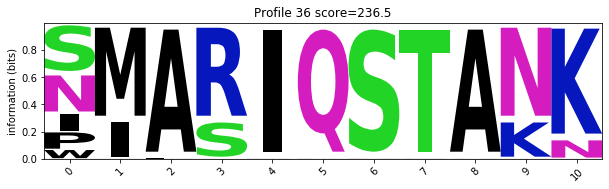

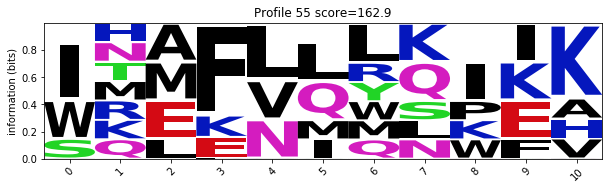

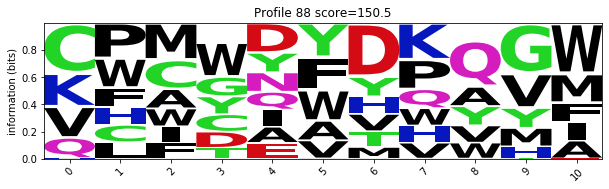

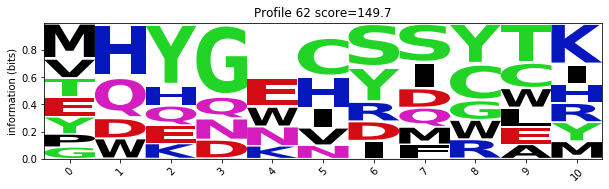

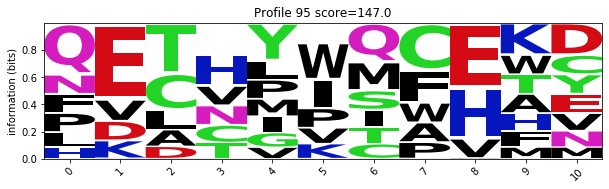

In [13]:
P = specProModel.getP()
plotLogo(P=P, idxarray = np.argsort(-pScores), pScores=pScores, max_print=5)
# should be similar to one of ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']

In [14]:
# dataset = tf.data.Dataset.from_tensor_slices([X])